In [1]:
# %pip install seaborn
# %pip install xgboost
# %pip install catboost
# %pip install missingno
# %pip install scikit-learn==1.2.2
# %pip install rasterio pyproj rioxarray
# %pip install pykrige
# %pip install pyinterpolate

## Load In Dependencies

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score

# Evaluation Metrics
from sklearn.metrics import r2_score

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
from scipy.spatial import cKDTree
from pykrige.ok import OrdinaryKriging
import missingno as msno
import os
from tqdm import tqdm

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("data/Training_data_uhi_index_UHI2025-v2.csv")
ground_df

Longitude   Latitude          datetime  UHI Index
0     -73.909167  40.813107  24-07-2021 15:53   1.030289
1     -73.909187  40.813045  24-07-2021 15:53   1.030289
2     -73.909215  40.812978  24-07-2021 15:53   1.023798
3     -73.909242  40.812908  24-07-2021 15:53   1.023798
4     -73.909257  40.812845  24-07-2021 15:53   1.021634
...          ...        ...               ...        ...
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408

[11229 rows x 4 columns]

## Predictor Variables

### Extracting GeoTIFF Image

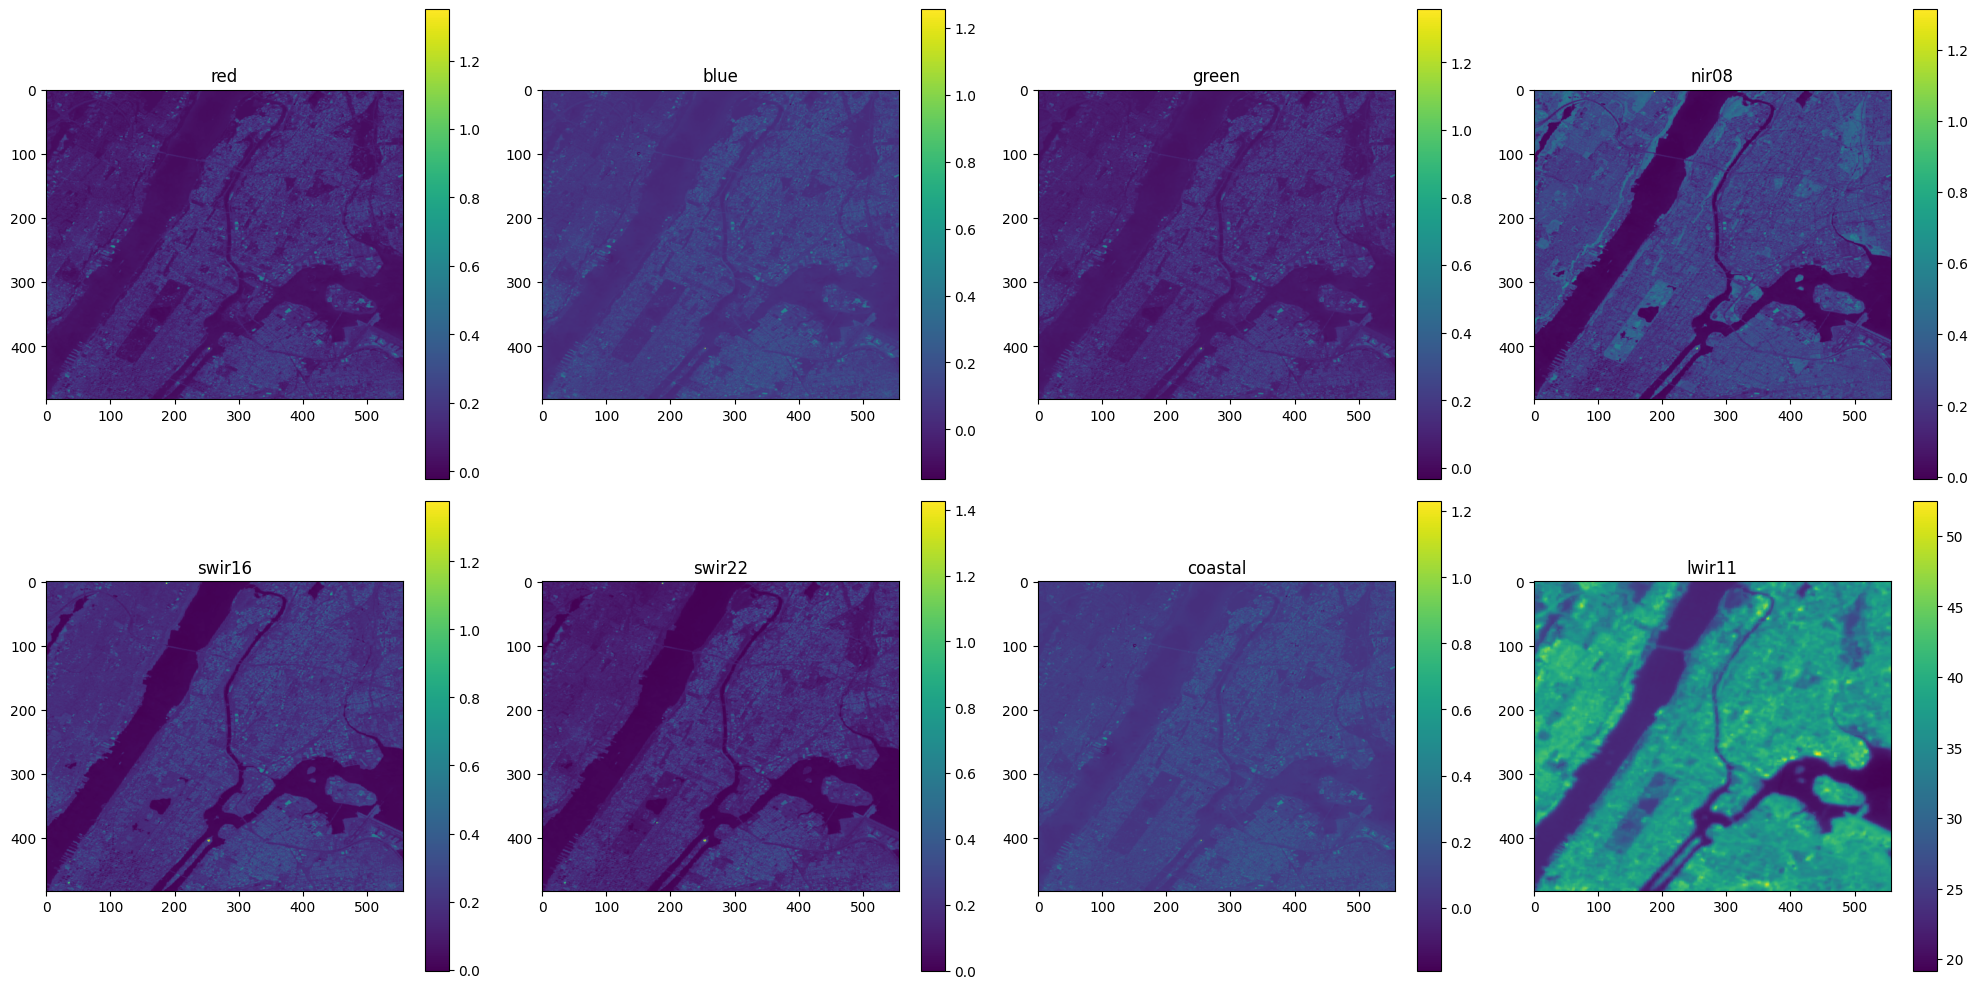

In [4]:
# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/landsat_8.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    red = dst.read(1)
    blue = dst.read(2)
    green = dst.read(3)
    nir08 = dst.read(4)
    swir16 = dst.read(5)
    swir22 = dst.read(6)
    coastal = dst.read(7) 
    lwir11 = dst.read(8)

band_name = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11'] 
band_lst = [red, blue, green, nir08, swir16, swir22, coastal, lwir11]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


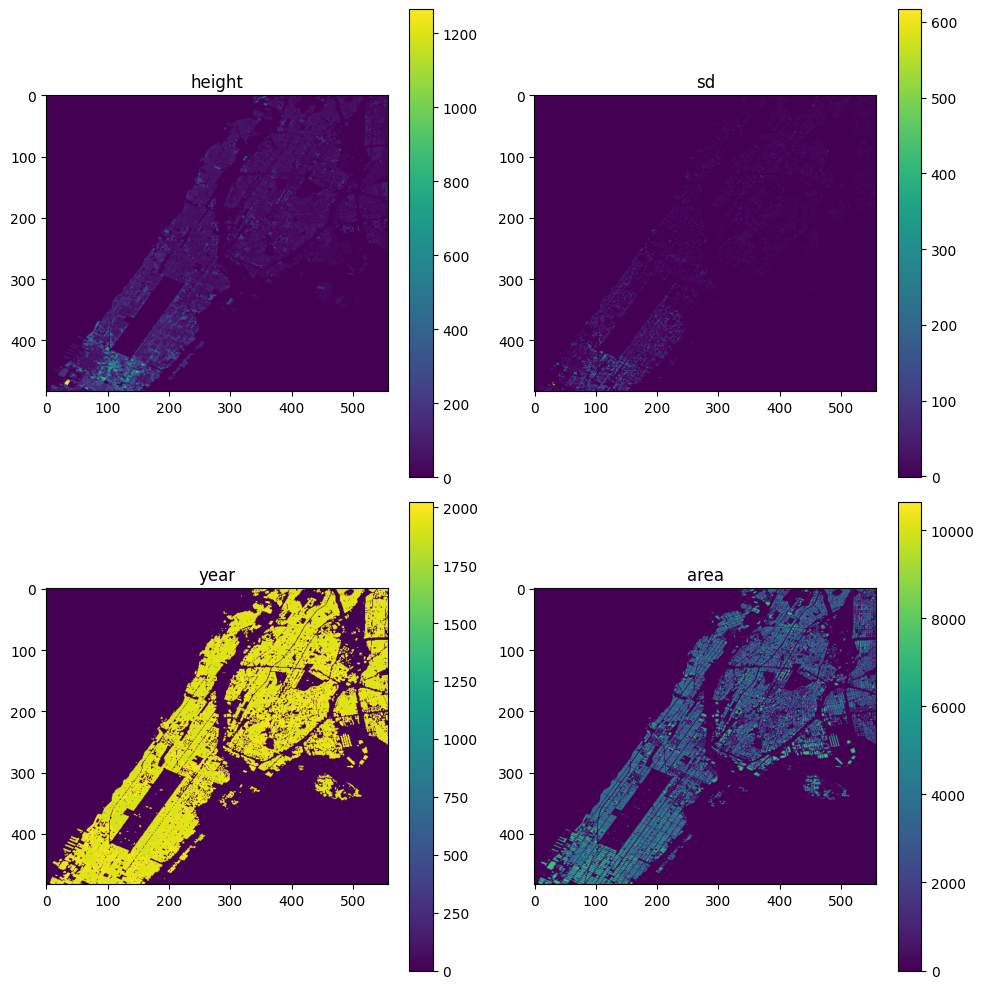

In [5]:
# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/building_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    building_height = dst.read(1)
    building_sd = dst.read(2)
    building_year = dst.read(3)
    building_area = dst.read(4)

band_name = ['height', 'sd', 'year', 'area']
band_lst = [building_height, building_sd, building_year, building_area]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


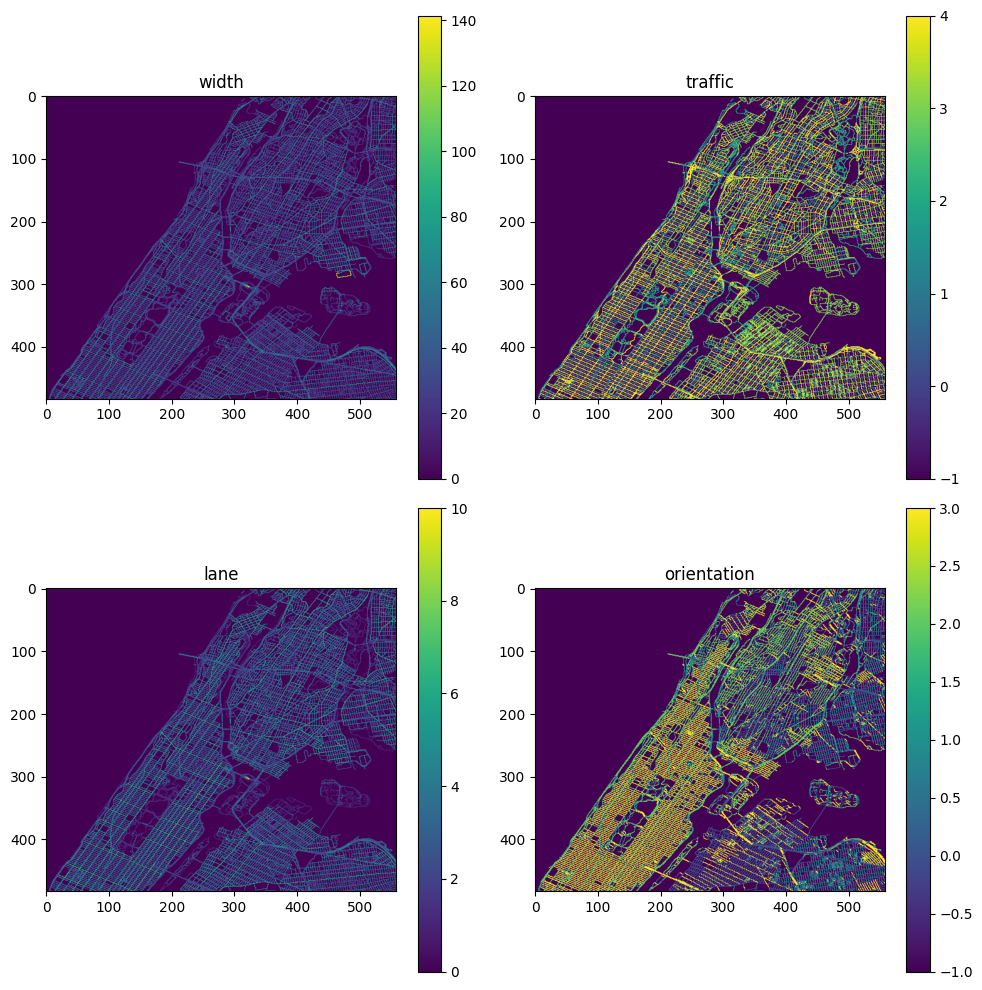

In [6]:
# Open the GeoTIFF file
tiff_path = "data_pipeline/data/tiff/street_res30.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    street_width = dst.read(1)
    traffic_dir = dst.read(2)
    street_lane = dst.read(3)
    orientation = dst.read(4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

band_lst = [street_width, traffic_dir, street_lane, orientation]
band_name = ['width', 'traffic', 'lane', 'orientation']

# Flatten the axes for easier indexing
axes = axes.flatten()

for i in range(len(band_lst)):
    im = axes[i].imshow(band_lst[i], cmap='viridis')
    axes[i].set_title(band_name[i])
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


Metadata
driver: GTiff
dtype: float64
nodata: None
width: 17
height: 15
count: 1
crs: EPSG:4326
transform: | 0.01, 0.00,-74.01|
| 0.00,-0.01, 40.88|
| 0.00, 0.00, 1.00|
blockxsize: 256
blockysize: 256
tiled: True
compress: deflate
interleave: band


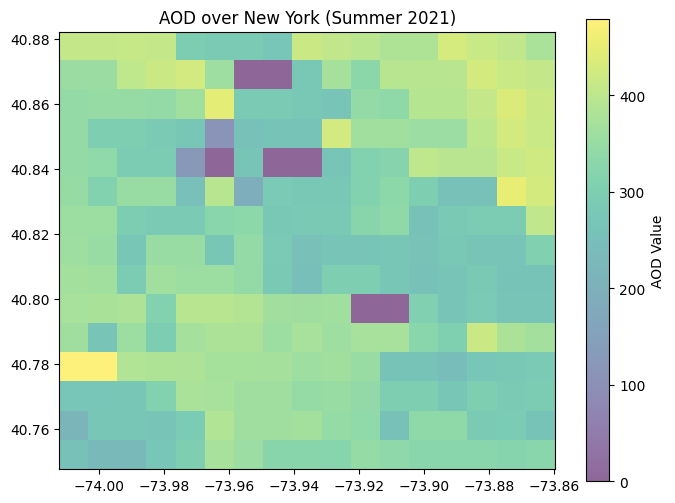

In [216]:
# tif. file path
tif_file = "data_pipeline\\data\\air_quality\AOD_NewYork_Summer2021.tif"

# Open tif. file
with rasterio.open(tif_file) as src:
    aod_data = src.read(1)  
    profile = src.profile 
    bounds = src.bounds

print("Metadata")
for key, value in profile.items():
    print(f"{key}: {value}")


plt.figure(figsize=(8, 6))
plt.imshow(aod_data, cmap="viridis", interpolation="nearest",
           extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
           alpha=0.6)
plt.colorbar(label="AOD Value")
plt.title("AOD over New York (Summer 2021)")
plt.show()

### Extracting Band Values from the GeoTIFF Image


In [7]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path, col_name):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    layer_num = 0
    with rasterio.open(tiff_path) as dts:
        layer_num = dts.count

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values   

    df = pd.DataFrame()
    for i in tqdm(range(layer_num), desc="Go through layer"):
        values = []
        # Iterate over the latitudes and longitudes, and extract the corresponding band values
        for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
            cell_value = data.sel(x=lon, y=lat,  band=i+1, method="nearest").values
            values.append(cell_value)
        # Add column of feature
        df[col_name[i]] = values
    
    return df


In [8]:
# Mapping satellite data with training data.
data_dir = "data_pipeline/data/tiff/"
landsat_bands = ['red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'coastal', 'lwir11']
landsat_data = map_satellite_data(data_dir+'landsat_8.tiff', 'data/Training_data_uhi_index_UHI2025-v2.csv',
                                landsat_bands)
landsat_data.head()

Go through layer: 100%|██████████| 8/8 [03:28<00:00, 26.01s/it]


red                 blue                green  \
0            0.0713975  0.04560249999999999  0.06952750000000002   
1            0.0713975  0.04560249999999999  0.06952750000000002   
2  0.10783500000000001              0.08875  0.10676249999999998   
3  0.10783500000000001              0.08875  0.10676249999999998   
4  0.10783500000000001              0.08875  0.10676249999999998   

                 nir08   swir16               swir22              coastal  \
0              0.20887  0.13649  0.09543249999999998  0.03925000000000001   
1              0.20887  0.13649  0.09543249999999998  0.03925000000000001   
2  0.23001749999999999    0.185            0.1352525  0.07574249999999999   
3  0.23001749999999999    0.185            0.1352525  0.07574249999999999   
4  0.23001749999999999    0.185            0.1352525  0.07574249999999999   

              lwir11  
0  37.78553354000002  
1  37.78553354000002  
2  37.35828104000001  
3  37.35828104000001  
4  37.35828104000001

In [9]:
# Mapping satellite data with training data.
building_bands = ['building_height', 'building_sd', 'building_year', 'building_area']
building_data = map_satellite_data(data_dir+'building_res30.tiff', 'data/Training_data_uhi_index_UHI2025-v2.csv',
                                building_bands)
building_data.head()

Go through layer:   0%|          | 0/4 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [01:01<00:00, 15.35s/it]


building_height building_sd building_year building_area
0            65.1         0.0        1928.0      936.1115
1            65.1         0.0        1928.0      936.1115
2             0.0        -1.0           0.0           0.0
3             0.0        -1.0           0.0           0.0
4             0.0        -1.0           0.0           0.0

In [10]:
# Mapping satellite data with training data.
street_bands = ['street_width', 'street_traffic', 'street_lane', 'street_orientation']
street_data = map_satellite_data(data_dir+'street_res30.tiff', 'data/Training_data_uhi_index_UHI2025-v2.csv',
                                street_bands)
street_data.head()

Go through layer:   0%|          | 0/4 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [00:59<00:00, 14.95s/it]


street_width street_traffic street_lane street_orientation
0         44.0            4.0         4.0                1.0
1         44.0            4.0         4.0                1.0
2         31.0            1.0   2.3333333                1.0
3         31.0            1.0   2.3333333                1.0
4         31.0            1.0   2.3333333                1.0

In [93]:
df = pd.read_csv('data/Training_data_uhi_index_UHI2025-v2.csv')
df = pd.concat([df, landsat_data, building_data, street_data], axis=1)
df

Longitude   Latitude          datetime  UHI Index                  red  \
0     -73.909167  40.813107  24-07-2021 15:53   1.030289            0.0713975   
1     -73.909187  40.813045  24-07-2021 15:53   1.030289            0.0713975   
2     -73.909215  40.812978  24-07-2021 15:53   1.023798  0.10783500000000001   
3     -73.909242  40.812908  24-07-2021 15:53   1.023798  0.10783500000000001   
4     -73.909257  40.812845  24-07-2021 15:53   1.021634  0.10783500000000001   
...          ...        ...               ...        ...                  ...   
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470              0.06488   
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470              0.06488   
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124              0.06488   
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245              0.06488   
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408              0.06488   

                      blue                green                nir08  \
0      0.04560249999999999  0.06952750000000002              0.20887   
1      0.04560249999999999  0.06952750000000002              0.20887   
2                  0.08875  0.10676249999999998  0.23001749999999999   
3                  0.08875  0.10676249999999998  0.23001749999999999   
4                  0.08875  0.10676249999999998  0.23001749999999999   
...                    ...                  ...                  ...   
11224  0.05126750000000002  0.07579750000000002             0.336745   
11225  0.05126750000000002  0.07579750000000002             0.336745   
11226  0.05126750000000002  0.07579750000000002             0.336745   
11227  0.05126750000000002  0.07579750000000002             0.336745   
11228  0.05126750000000002  0.07579750000000002             0.336745   

                    swir16               swir22              coastal  \
0                  0.13649  0.09543249999999998  0.03925000000000001   
1                  0.13649  0.09543249999999998  0.03925000000000001   
2                    0.185            0.1352525  0.07574249999999999   
3                    0.185            0.1352525  0.07574249999999999   
4                    0.185            0.1352525  0.07574249999999999   
...                    ...                  ...                  ...   
11224  0.18282749999999998            0.1048925  0.04862749999999999   
11225  0.18282749999999998            0.1048925  0.04862749999999999   
11226  0.18282749999999998            0.1048925  0.04862749999999999   
11227  0.18282749999999998            0.1048925  0.04862749999999999   
11228  0.18282749999999998            0.1048925  0.04862749999999999   

                  lwir11 building_height building_sd building_year  \
0      37.78553354000002            65.1         0.0        1928.0   
1      37.78553354000002            65.1         0.0        1928.0   
2      37.35828104000001             0.0        -1.0           0.0   
3      37.35828104000001             0.0        -1.0           0.0   
4      37.35828104000001             0.0        -1.0           0.0   
...                  ...             ...         ...           ...   
11224  30.44020856000003             0.0        -1.0           0.0   
11225  30.44020856000003             0.0        -1.0           0.0   
11226  30.44020856000003             0.0        -1.0           0.0   
11227  30.44020856000003             0.0        -1.0           0.0   
11228  30.44020856000003             0.0        -1.0           0.0   

      building_area street_width street_traffic street_lane street_orientation  
0          936.1115         44.0            4.0         4.0                1.0  
1          936.1115         44.0            4.0         4.0                1.0  
2               0.0         31.0            1.0   2.3333333                1.0  
3               0.0         31.0            1.0   2.3333333                1.0  
4               0.0         31.0            1.0   2.333333

### Environmental Indices


In [94]:
# NDVI (Normalized Difference Vegetation Index) 
df['ndvi'] = (df['nir08'] - df['red']) / (df['nir08'] + df['red'])

# EVI (Enhanced Vegetation Index)
df["evi"] = 2.5 * (df['nir08'] - df['red']) / (df['nir08'] + 6 * df['red'] - 7.5 * df['blue'] + 1 + 1e-10)

# SAVI (Soil Adjusted Vegetation Index)
df["savi"] = (df['nir08'] - df['red']) * 1.5 / (df['nir08'] + df['red'] + 0.5 + 1e-10)

# GNDVI (Green Normalized Difference Vegetation Index)
df["gndvi"] = (df['nir08'] - df['green']) / (df['nir08'] + df['green'] + 1e-10)

# ARVI (Atmospherically Resistant Vegetation Index)
df["arvi"] = (df['nir08'] - (df['red'] - (df['blue'] - df['red']))) / (df['nir08'] + (df['red'] - (df['blue'] - df['red'])) + 1e-10)

# MSAVI (Modified Soil-Adjusted Vegetation Index)
df["msavi"] = (2 * df['nir08'] + 1 - ((2 * df['nir08'] + 1) ** 2 - 8 * (df['nir08'] - df['red'])) ** 0.5) / 2

# NDWI (Normalized Difference Water Index)
df['ndwi'] = (df['green'] - df['nir08']) / (df['green'] + df['nir08'])

# MNDWI (Modified Normalized Difference Water Index)
df["mndwi"] = (df['green'] - df['swir16']) / (df['green'] + df['swir16'] + 1e-10)

# AWEI_NSH (Automated Water Extraction Index - No Shadows)
df["awei_nsh"] = 4 * (df['green'] - df['swir16']) - (0.25 * df['nir08'] + 2.75 * df['swir22'])

# AWEI_SH (Automated Water Extraction Index - Shadows)
df["awei_sh"] = df['green'] + 2.5 * df['nir08'] - 1.5 * (df['swir16'] + df['swir22']) - 0.25 * df['blue']

# NDSI (Normalized Difference Snow Index)
df["ndsi"] = (df['green'] - df['swir16']) / (df['green'] + df['swir16'] + 1e-10)

# NBR (Normalized Burn Ratio)
df["nbr"] = (df['nir08'] - df['swir22']) / (df['nir08'] + df['swir22'] + 1e-10)

# SI (Shadow Index or Soil Index)
df["si"] = (df['swir16'] - df['blue']) / (df['swir16'] + df['blue'] + 1e-10)
    
# NDBI (Normalized Difference Building Index)
df['ndbi'] = (df['swir16'] - df['nir08']) / (df['swir16'] + df['nir08'])

# UI (Urban Index)
df["ui"] = (df['swir16'] - df['red']) / (df['swir16'] + df['red'] + 1e-10)

# IBI (Index-based Built-up Index)
df["ibi"] = (df["ndbi"] - (df["savi"] + df["mndwi"])) / (df["ndbi"] + (df["savi"] + df["mndwi"]) + 1e-10)
                                                         
# Albedo (Surface Reflectance Index)
df['albedo'] = (0.356 * df['blue'] + 0.130 * df['red'] + 0.373 * df['nir08'] + 0.085 * df['swir16'] + 0.072 * df['swir22'] - 0.018) / 1.016


### VAR (Vertical Aspect Ratio) and Building Area per Pixel


In [95]:
# Calculate the VAR (Vertical Aspect Ratio)
df['VAR'] = df['building_height'] / df['street_width']
df['VAR'] = df['VAR'].replace([np.inf, -np.inf], np.nan)

# Calculate the building's area per pixel area (30 x 30 m^2)
df['Building_area_per_pixel'] = df['building_area'] / (900 * 10.764)
df['Building_area_per_pixel'] = df['Building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

### Air Quality

In [ ]:
# # Load air quality dataset (e.g., CO)
# co_data = pd.read_csv("data_pipeline\\data\\air_quality\\co_data_mean_and_std.csv")  # Replace with actual path
# co_coords = co_data[["longitude", "latitude"]].values
# co_values = co_data["average_CO"].values

# # Create KDTree for nearest neighbor search
# tree = cKDTree(co_coords)

# # Find the nearest point in the air quality dataset for each point in the main dataset
# distances, indices = tree.query(df[['Longitude', 'Latitude']].values, k=1)

# # Assign CO values to the main dataset
# df["CO_index"] = co_values[indices]

Longitude   Latitude          datetime  UHI Index                  red  \
0     -73.909167  40.813107  24-07-2021 15:53   1.030289            0.0713975   
1     -73.909187  40.813045  24-07-2021 15:53   1.030289            0.0713975   
2     -73.909215  40.812978  24-07-2021 15:53   1.023798  0.10783500000000001   
3     -73.909242  40.812908  24-07-2021 15:53   1.023798  0.10783500000000001   
4     -73.909257  40.812845  24-07-2021 15:53   1.021634  0.10783500000000001   
...          ...        ...               ...        ...                  ...   
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470              0.06488   
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470              0.06488   
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124              0.06488   
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245              0.06488   
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408              0.06488   

                      blue                green                nir08  \
0      0.04560249999999999  0.06952750000000002              0.20887   
1      0.04560249999999999  0.06952750000000002              0.20887   
2                  0.08875  0.10676249999999998  0.23001749999999999   
3                  0.08875  0.10676249999999998  0.23001749999999999   
4                  0.08875  0.10676249999999998  0.23001749999999999   
...                    ...                  ...                  ...   
11224  0.05126750000000002  0.07579750000000002             0.336745   
11225  0.05126750000000002  0.07579750000000002             0.336745   
11226  0.05126750000000002  0.07579750000000002             0.336745   
11227  0.05126750000000002  0.07579750000000002             0.336745   
11228  0.05126750000000002  0.07579750000000002             0.336745   

                    swir16               swir22  ...      ndbi        ui  \
0                  0.13649  0.09543249999999998  ... -0.209578  0.313114   
1                  0.13649  0.09543249999999998  ... -0.209578  0.313114   
2                    0.185            0.1352525  ... -0.108471   0.26351   
3                    0.185            0.1352525  ... -0.108471   0.26351   
4                    0.185            0.1352525  ... -0.108471   0.26351   
...                    ...                  ...  ...       ...       ...   
11224  0.18282749999999998            0.1048925  ... -0.296239  0.476156   
11225  0.18282749999999998            0.1048925  ... -0.296239  0.476156   
11226  0.18282749999999998            0.1048925  ... -0.296239  0.476156   
11227  0.18282749999999998            0.1048925  ... -0.296239  0.476156   
11228  0.18282749999999998            0.1048925  ... -0.296239  0.476156   

            ibi    albedo       VAR Building_area_per_pixel Interpolated_CO  \
0      0.550527  0.102261  1.479545                 0.09663        0.253650   
1      0.550527  0.102261  1.479545                 0.09663        0.253647   
2      0.374065  0.136686  0.000000                 0.00000        0.253643   
3      0.374065  0.136686  0.000000                 0.00000        0.253639   
4      0.374065  0.136686  0.000000                 0.00000        0.253636   
...         ...       ...       ...                     ...             ...   
11224    1.2983  0.154906  0.000000                 0.00000        0.252979   
11225    1.2983  0.154906  0.000000                 0.00000        0.252988   
11226    1.2983  0.154906  0.000000                 0.00000        0.253005   
11227    1.2983  0.154906  0.000000                 0.00000        0.253014   
11228    1.2983  0.154906  0.000000                 0.00000        0.253022   

      Interpolated_SO2 Interpolated_NO2 Interpolated_O3  
0             0.083337        11.679984        0.031661  
1             0.083375        11.679726        0.031661  
2             0.083423        11.679401        0.031661  
3             0.083471        11.679076        0.031661  
4             0.0

In [ ]:
air_quality_files = {
    "CO": "data_pipeline\\data\\air_quality\\co_data_mean_and_std.csv",
    "SO2": "data_pipeline\\data\\air_quality\\so2_data_mean_and_std.csv",
    "NO2": "data_pipeline\\data\\air_quality\\no2_data_mean_and_std.csv",
    "O3": "data_pipeline\\data\\air_quality\\o3_data_mean_and_std.csv",
    "PM10": "data_pipeline\\data\\air_quality\\pm10_data_mean_and_std.csv",
    "PM25": "data_pipeline\\data\\air_quality\\pm2.5_data_mean_and_std.csv",
    "VOC": "data_pipeline\\data\\air_quality\\voc_data_mean_and_std.csv",
    "NO": "data_pipeline\\data\\air_quality\\no_data_mean_and_std.csv",
}

# Iterate over each air quality dataset and map values using KNN
# for key, file_path in air_quality_files.items():
#     # Load the air quality dataset
#     air_quality_data = pd.read_csv(file_path)
    
#     # Extract coordinates and values
#     aq_coords = air_quality_data[["longitude", "latitude"]].values
#     avg_values = air_quality_data[f"average_{key}"].values
#     std_values = air_quality_data[f"std_{key}"].values
    
#     # Create KDTree for nearest neighbor search
#     tree = cKDTree(aq_coords)
    
#     # Find the nearest point for each coordinate in the main dataset
#     distances, indices = tree.query(df[['Longitude', 'Latitude']], k=1)  # k=1 means nearest neighbor
    
#     # Assign values to the main dataset
#     df[f"Mean_nearest_{key}"] = avg_values[indices]
#     df[f"Std_{key}"] = std_values[indices]
    
def idw_interpolation(air_quality_file, param_name, power=1):
    """ Apply IDW interpolation for a given air quality parameter. """
    
    # Load air quality data
    air_quality_df = pd.read_csv(air_quality_file)
    
    # Extract known data points
    known_lons = air_quality_df["longitude"].values
    known_lats = air_quality_df["latitude"].values
    known_values = air_quality_df["average_" + param_name].values  # Using mean values
    
    # Create KDTree for fast nearest neighbor search
    tree = cKDTree(list(zip(known_lons, known_lats)))

    # Perform interpolation for each point in df
    interpolated_values = []
    for lon, lat in zip(df["Longitude"], df["Latitude"]):
        distances, indices = tree.query([lon, lat], k=len(known_lons))  # Use all available points

        if len(known_values) < 2:
            interpolated_values.append(np.nan)
            continue

        weights = 1 / (distances**power + 1e-10)
        interpolated_value = np.sum(weights * known_values[indices]) / np.sum(weights)
        interpolated_values.append(interpolated_value)

    # Add interpolated values to df
    df["Interpolated_" + param_name] = interpolated_values

# Apply IDW for each air quality parameter
for param, file_path in air_quality_files.items():
    idw_interpolation(file_path, param)

# AOD (Aerosol Optical Depth)
# df['AOD'] = df['blue'] / df['red'] + 1e-10
tif_file_name = "data_pipeline\\data\\air_quality\AOD_NewYork_Summer2021.tif"
aod_band = ['']
map_satellite_data(tif_file_name, 'data/Training_data_uhi_index_UHI2025-v2.csv', aod_band)

In [101]:
# # AOD (Aerosol Optical Depth)
# df['AOD'] = df['blue'] / df['red'] + 1e-10

# # PM2.5
# conversion_factor = 52
# df['PM_2.5'] = df['AOD'] * conversion_factor + 1e-10

# # NO2
# df['NO2'] = df['blue'] / df['green'] + 1e-10

# # SO2
# df['SO2'] = df['swir16'] - df['swir22'] + 1e-10

## EDA

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Longitude                11229 non-null  float64 
 1   Latitude                 11229 non-null  float64 
 2   datetime                 11229 non-null  object  
 3   UHI Index                11229 non-null  float64 
 4   red                      11229 non-null  float64 
 5   blue                     11229 non-null  float64 
 6   green                    11229 non-null  float64 
 7   nir08                    11229 non-null  float64 
 8   swir16                   11229 non-null  float64 
 9   swir22                   11229 non-null  float64 
 10  coastal                  11229 non-null  float64 
 11  lwir11                   11229 non-null  float64 
 12  building_height          11229 non-null  float64 
 13  building_sd              11229 non-null  float64 
 14  buildi

In [175]:
excluded_cols = ['Longitude', 'Latitude', 'datetime', 'UHI Index']
categorical_cols = ['street_traffic', 'street_orientation']
numerical_cols = df.columns.difference(categorical_cols + excluded_cols)


In [176]:
df[numerical_cols] = df[numerical_cols].astype('float')

In [177]:
df[categorical_cols] = df[categorical_cols].astype('float')
df[categorical_cols] = df[categorical_cols].astype('category')

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Longitude                11229 non-null  float64 
 1   Latitude                 11229 non-null  float64 
 2   datetime                 11229 non-null  object  
 3   UHI Index                11229 non-null  float64 
 4   red                      11229 non-null  float64 
 5   blue                     11229 non-null  float64 
 6   green                    11229 non-null  float64 
 7   nir08                    11229 non-null  float64 
 8   swir16                   11229 non-null  float64 
 9   swir22                   11229 non-null  float64 
 10  coastal                  11229 non-null  float64 
 11  lwir11                   11229 non-null  float64 
 12  building_height          11229 non-null  float64 
 13  building_sd              11229 non-null  float64 
 14  buildi

### Mising values

<Axes: >

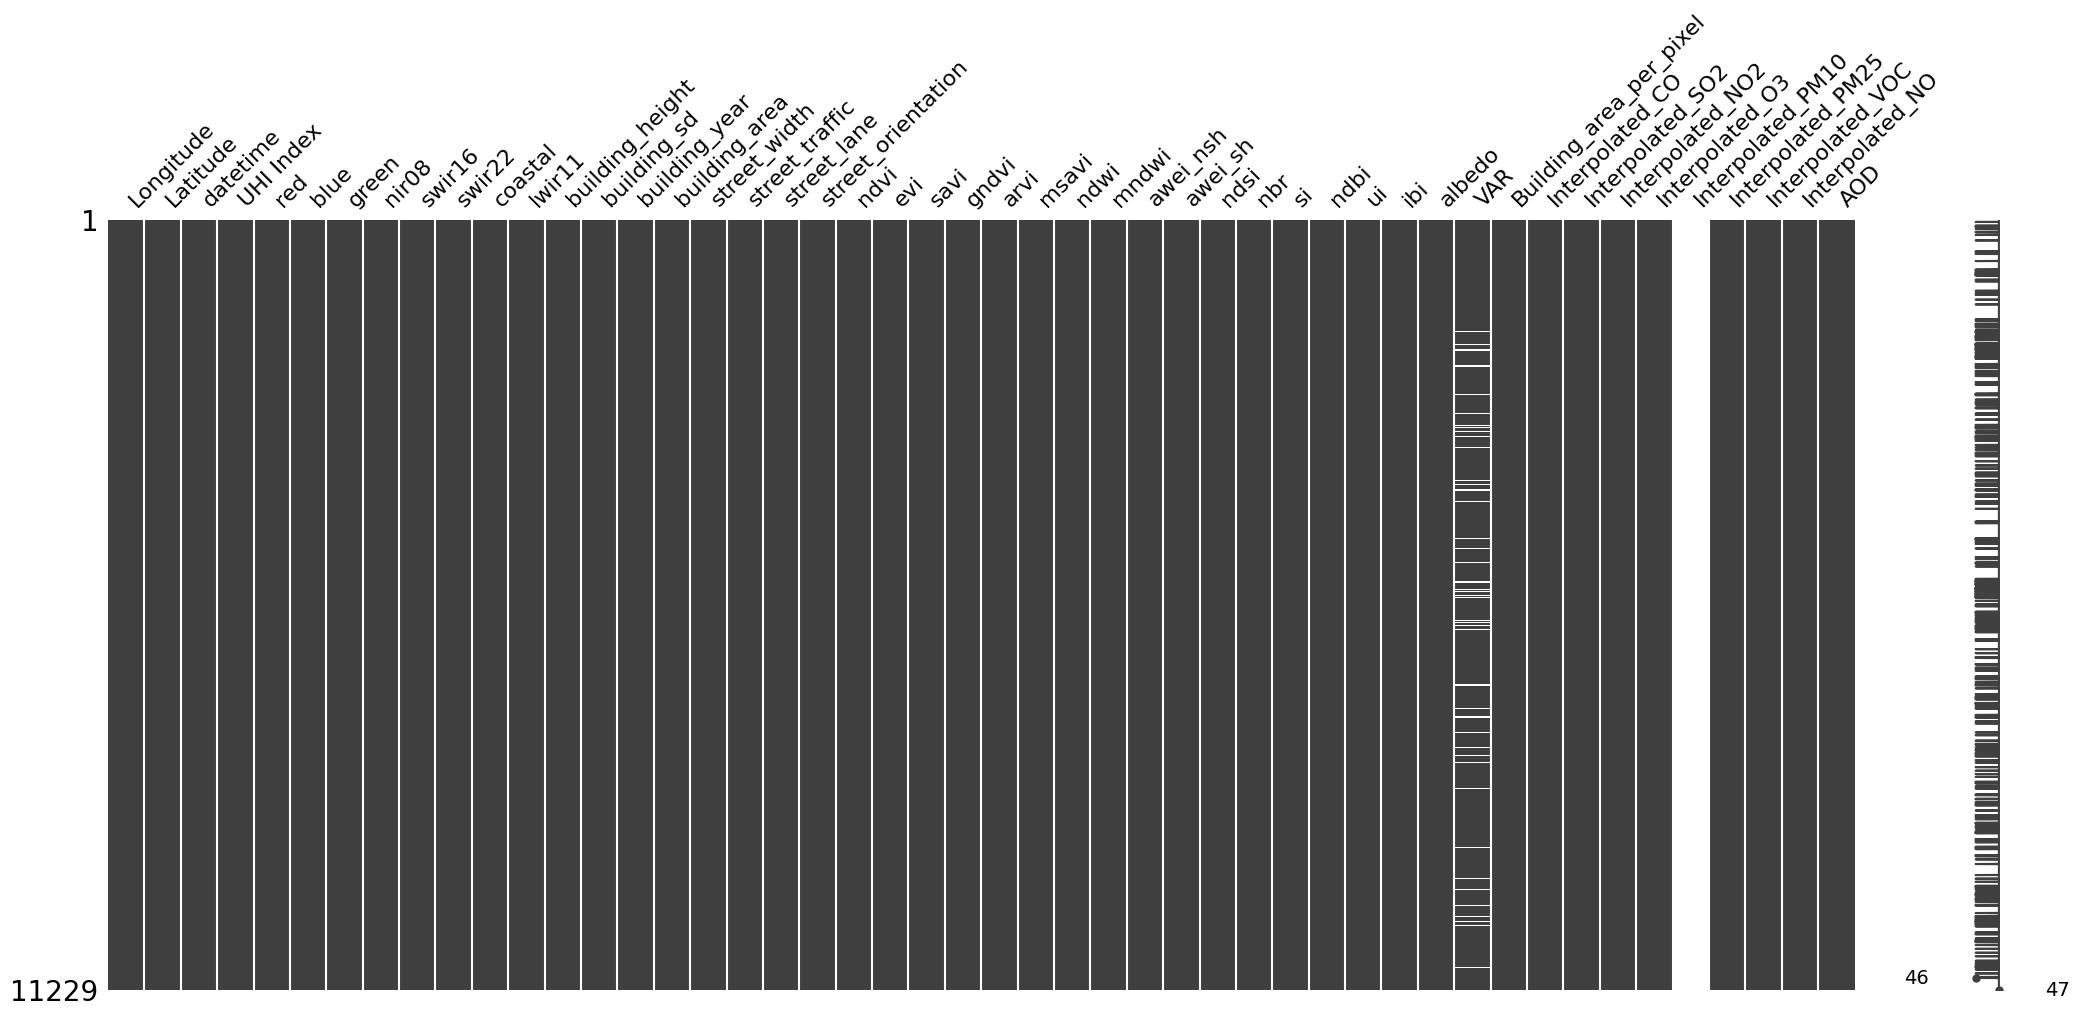

In [179]:
msno.matrix(df)

### UHI Index

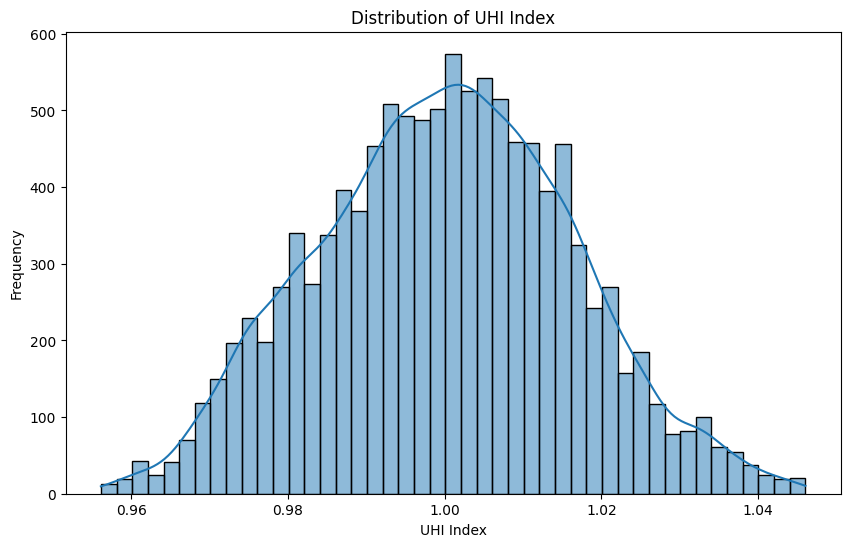

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df['UHI Index'], bins='auto', kde=True)
plt.title('Distribution of UHI Index')
plt.xlabel('UHI Index')
plt.ylabel('Frequency')
plt.show()

### Bla blaa

## Data Preprocesing

In [193]:
uhi_data = df.drop(columns=['Longitude', 'Latitude', 'datetime'])
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
...          ...       ...       ...       ...       ...       ...       ...   
11224   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11225   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  building_sd  building_year  \
0      0.039250  37.785534        65.099998          0.0         1928.0   
1      0.039250  37.785534        65.099998          0.0         1928.0   
2      0.075742  37.358281         0.000000         -1.0            0.0   
3      0.075742  37.358281         0.000000         -1.0            0.0   
4      0.075742  37.358281         0.000000         -1.0            0.0   
...         ...        ...              ...          ...            ...   
11224  0.048627  30.440209         0.000000         -1.0            0.0   
11225  0.048627  30.440209         0.000000         -1.0            0.0   
11226  0.048627  30.440209         0.000000         -1.0            0.0   
11227  0.048627  30.440209         0.000000         -1.0            0.0   
11228  0.048627  30.440209         0.000000         -1.0            0.0   

       building_area  street_width street_traffic  street_lane  \
0         936.111511          44.0            4.0     4.000000   
1         936.111511          44.0            4.0     4.000000   
2           0.000000          31.0            1.0     2.333333   
3           0.000000          31.0            1.0     2.333333   
4           0.000000          31.0            1.0     2.333333   
...              ...           ...            ...          ...   
11224       0.000000          37.5            4.0     1.000000   
11225       0.000000          37.5            4.0     1.000000   
11226       0.000000          37.5            4.0     1.000000   
11227       0.000000          37.5            4.0     1.000000   
11228       0.000000          37.5            4.0     1.000000   

      street_orientation      ndvi       evi      savi     gndvi      arvi  \
0                    1.0  0.490505  0.265343  0.264280  0.500516  0.364885   
1                    1.0  0.490505  0.265343  0.264280  0.500516  0.364885   
2                    1.0  0.361645  0.252151  0.218742  0.365981  0.288839   
3                    1.0  0.361645  0.252151  0.218742  0.365981  0.288839   
4                    1.0  0.361645  0.252151  0.218742  0.365981  0.288839   
...                  ...       ...       ...       ...       ...       ...   
11224                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11225                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11226                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11227                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11228                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   

          msavi      ndwi     mndwi  awei_nsh   awei_sh      ndsi       nbr  \
0      0.231846 -0.500516 -0.325033 -0.582507  0.232418 -0.325033  0.372779   
1      0.231846 -0.500516 -0.325033 -0.582507  0.232418 -0.325033  0.372779   
2      0.192839 -0.365981 -0.268155 -0.742399  0.179240 -0.268155  0.259438   
3      0.192839 -0.365981 -0.268155 -0.742399  0.179240 -0.268155  0.259438   
4      0.192839 -0.3

### Missing values

In [194]:
# uhi_data['VAR'].fillna(uhi_data['VAR'].mean(), inplace=True)
uhi_data['VAR'].fillna(1000, inplace=True)
uhi_data['Interpolated_PM10'].fillna(16.84375, inplace=True)
# uhi_data.drop(columns=['Interpolated_PM10'], inplace=True)

In [195]:
uhi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UHI Index                11229 non-null  float64 
 1   red                      11229 non-null  float64 
 2   blue                     11229 non-null  float64 
 3   green                    11229 non-null  float64 
 4   nir08                    11229 non-null  float64 
 5   swir16                   11229 non-null  float64 
 6   swir22                   11229 non-null  float64 
 7   coastal                  11229 non-null  float64 
 8   lwir11                   11229 non-null  float64 
 9   building_height          11229 non-null  float64 
 10  building_sd              11229 non-null  float64 
 11  building_year            11229 non-null  float64 
 12  building_area            11229 non-null  float64 
 13  street_width             11229 non-null  float64 
 14  street

### Removing duplicates

In [196]:
# Check the duplicated records
print(f'Duplicated Rows: {uhi_data.duplicated().sum()}')

Duplicated Rows: 0


In [197]:
uhi_data.columns

Index(['UHI Index', 'red', 'blue', 'green', 'nir08', 'swir16', 'swir22',
       'coastal', 'lwir11', 'building_height', 'building_sd', 'building_year',
       'building_area', 'street_width', 'street_traffic', 'street_lane',
       'street_orientation', 'ndvi', 'evi', 'savi', 'gndvi', 'arvi', 'msavi',
       'ndwi', 'mndwi', 'awei_nsh', 'awei_sh', 'ndsi', 'nbr', 'si', 'ndbi',
       'ui', 'ibi', 'albedo', 'VAR', 'Building_area_per_pixel',
       'Interpolated_CO', 'Interpolated_SO2', 'Interpolated_NO2',
       'Interpolated_O3', 'Interpolated_PM10', 'Interpolated_PM25',
       'Interpolated_VOC', 'Interpolated_NO', 'AOD'],
      dtype='object')

In [198]:
# # Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
# columns = ['lwir11', 'building_height', 'building_year', 'ndvi', 'ndbi', 'ndwi', 'street_width', 'building_area']
# for col in columns:
#     # Check if the value is a numpy array and has more than one dimension
#     uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# # Now remove duplicates
uhi_data = uhi_data.drop_duplicates(keep='first')
uhi_data


UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
...          ...       ...       ...       ...       ...       ...       ...   
11224   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11225   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  building_sd  building_year  \
0      0.039250  37.785534        65.099998          0.0         1928.0   
1      0.039250  37.785534        65.099998          0.0         1928.0   
2      0.075742  37.358281         0.000000         -1.0            0.0   
3      0.075742  37.358281         0.000000         -1.0            0.0   
4      0.075742  37.358281         0.000000         -1.0            0.0   
...         ...        ...              ...          ...            ...   
11224  0.048627  30.440209         0.000000         -1.0            0.0   
11225  0.048627  30.440209         0.000000         -1.0            0.0   
11226  0.048627  30.440209         0.000000         -1.0            0.0   
11227  0.048627  30.440209         0.000000         -1.0            0.0   
11228  0.048627  30.440209         0.000000         -1.0            0.0   

       building_area  street_width street_traffic  street_lane  \
0         936.111511          44.0            4.0     4.000000   
1         936.111511          44.0            4.0     4.000000   
2           0.000000          31.0            1.0     2.333333   
3           0.000000          31.0            1.0     2.333333   
4           0.000000          31.0            1.0     2.333333   
...              ...           ...            ...          ...   
11224       0.000000          37.5            4.0     1.000000   
11225       0.000000          37.5            4.0     1.000000   
11226       0.000000          37.5            4.0     1.000000   
11227       0.000000          37.5            4.0     1.000000   
11228       0.000000          37.5            4.0     1.000000   

      street_orientation      ndvi       evi      savi     gndvi      arvi  \
0                    1.0  0.490505  0.265343  0.264280  0.500516  0.364885   
1                    1.0  0.490505  0.265343  0.264280  0.500516  0.364885   
2                    1.0  0.361645  0.252151  0.218742  0.365981  0.288839   
3                    1.0  0.361645  0.252151  0.218742  0.365981  0.288839   
4                    1.0  0.361645  0.252151  0.218742  0.365981  0.288839   
...                  ...       ...       ...       ...       ...       ...   
11224                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11225                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11226                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11227                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   
11228                2.0  0.676913  0.506637  0.452292  0.632535  0.621939   

          msavi      ndwi     mndwi  awei_nsh   awei_sh      ndsi       nbr  \
0      0.231846 -0.500516 -0.325033 -0.582507  0.232418 -0.325033  0.372779   
1      0.231846 -0.500516 -0.325033 -0.582507  0.232418 -0.325033  0.372779   
2      0.192839 -0.365981 -0.268155 -0.742399  0.179240 -0.268155  0.259438   
3      0.192839 -0.365981 -0.268155 -0.742399  0.179240 -0.268155  0.259438   
4      0.192839 -0.3

In [199]:
# Resetting the index of the dataset
uhi_data = uhi_data.reset_index(drop=True)

### Encoding

In [200]:
# One-hot encodiing
uhi_data = pd.get_dummies(data=uhi_data, columns=categorical_cols)
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
...          ...       ...       ...       ...       ...       ...       ...   
11224   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11225   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  building_sd  building_year  \
0      0.039250  37.785534        65.099998          0.0         1928.0   
1      0.039250  37.785534        65.099998          0.0         1928.0   
2      0.075742  37.358281         0.000000         -1.0            0.0   
3      0.075742  37.358281         0.000000         -1.0            0.0   
4      0.075742  37.358281         0.000000         -1.0            0.0   
...         ...        ...              ...          ...            ...   
11224  0.048627  30.440209         0.000000         -1.0            0.0   
11225  0.048627  30.440209         0.000000         -1.0            0.0   
11226  0.048627  30.440209         0.000000         -1.0            0.0   
11227  0.048627  30.440209         0.000000         -1.0            0.0   
11228  0.048627  30.440209         0.000000         -1.0            0.0   

       building_area  street_width  street_lane      ndvi       evi      savi  \
0         936.111511          44.0     4.000000  0.490505  0.265343  0.264280   
1         936.111511          44.0     4.000000  0.490505  0.265343  0.264280   
2           0.000000          31.0     2.333333  0.361645  0.252151  0.218742   
3           0.000000          31.0     2.333333  0.361645  0.252151  0.218742   
4           0.000000          31.0     2.333333  0.361645  0.252151  0.218742   
...              ...           ...          ...       ...       ...       ...   
11224       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11225       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11226       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11227       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11228       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   

          gndvi      arvi     msavi      ndwi     mndwi  awei_nsh   awei_sh  \
0      0.500516  0.364885  0.231846 -0.500516 -0.325033 -0.582507  0.232418   
1      0.500516  0.364885  0.231846 -0.500516 -0.325033 -0.582507  0.232418   
2      0.365981  0.288839  0.192839 -0.365981 -0.268155 -0.742399  0.179240   
3      0.365981  0.288839  0.192839 -0.365981 -0.268155 -0.742399  0.179240   
4      0.365981  0.288839  0.192839 -0.365981 -0.268155 -0.742399  0.179240   
...         ...       ...       ...       ...       ...       ...       ...   
11224  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11225  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11226  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11227  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11228  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   

           ndsi       nbr        si      ndbi        ui       ibi    albedo  \
0     -0.325033  0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261   
1     -0.325033  0.372779  0.499128 -0.209578  0.313114  0.550527

## Model Building

In [201]:
flag = 1
if flag == 1:   
    # pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
else:
    pd.reset_option('display.max_rows', None)
    pd.reset_option('display.max_columns', None)
uhi_data

UHI Index       red      blue     green     nir08    swir16    swir22  \
0       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
1       1.030289  0.071398  0.045602  0.069528  0.208870  0.136490  0.095432   
2       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
3       1.023798  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
4       1.021634  0.107835  0.088750  0.106762  0.230017  0.185000  0.135252   
...          ...       ...       ...       ...       ...       ...       ...   
11224   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11225   0.972470  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11226   0.981124  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11227   0.981245  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   
11228   0.983408  0.064880  0.051268  0.075798  0.336745  0.182827  0.104892   

        coastal     lwir11  building_height  building_sd  building_year  \
0      0.039250  37.785534        65.099998          0.0         1928.0   
1      0.039250  37.785534        65.099998          0.0         1928.0   
2      0.075742  37.358281         0.000000         -1.0            0.0   
3      0.075742  37.358281         0.000000         -1.0            0.0   
4      0.075742  37.358281         0.000000         -1.0            0.0   
...         ...        ...              ...          ...            ...   
11224  0.048627  30.440209         0.000000         -1.0            0.0   
11225  0.048627  30.440209         0.000000         -1.0            0.0   
11226  0.048627  30.440209         0.000000         -1.0            0.0   
11227  0.048627  30.440209         0.000000         -1.0            0.0   
11228  0.048627  30.440209         0.000000         -1.0            0.0   

       building_area  street_width  street_lane      ndvi       evi      savi  \
0         936.111511          44.0     4.000000  0.490505  0.265343  0.264280   
1         936.111511          44.0     4.000000  0.490505  0.265343  0.264280   
2           0.000000          31.0     2.333333  0.361645  0.252151  0.218742   
3           0.000000          31.0     2.333333  0.361645  0.252151  0.218742   
4           0.000000          31.0     2.333333  0.361645  0.252151  0.218742   
...              ...           ...          ...       ...       ...       ...   
11224       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11225       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11226       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11227       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   
11228       0.000000          37.5     1.000000  0.676913  0.506637  0.452292   

          gndvi      arvi     msavi      ndwi     mndwi  awei_nsh   awei_sh  \
0      0.500516  0.364885  0.231846 -0.500516 -0.325033 -0.582507  0.232418   
1      0.500516  0.364885  0.231846 -0.500516 -0.325033 -0.582507  0.232418   
2      0.365981  0.288839  0.192839 -0.365981 -0.268155 -0.742399  0.179240   
3      0.365981  0.288839  0.192839 -0.365981 -0.268155 -0.742399  0.179240   
4      0.365981  0.288839  0.192839 -0.365981 -0.268155 -0.742399  0.179240   
...         ...       ...       ...       ...       ...       ...       ...   
11224  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11225  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11226  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11227  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   
11228  0.632535  0.621939  0.441255 -0.632535 -0.413842 -0.800761  0.473263   

           ndsi       nbr        si      ndbi        ui       ibi    albedo  \
0     -0.325033  0.372779  0.499128 -0.209578  0.313114  0.550527  0.102261   
1     -0.325033  0.372779  0.499128 -0.209578  0.313114  0.550527

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [202]:
# Split the data into features (X) and target (y), and then into training and testing sets
# columns = uhi_data.drop(columns=['UHI Index']).columns
# X = uhi_data[columns].values
X = uhi_data.drop(columns=['UHI Index'])
y = uhi_data['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

### Feature Scaling 

In [203]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])

<Axes: >

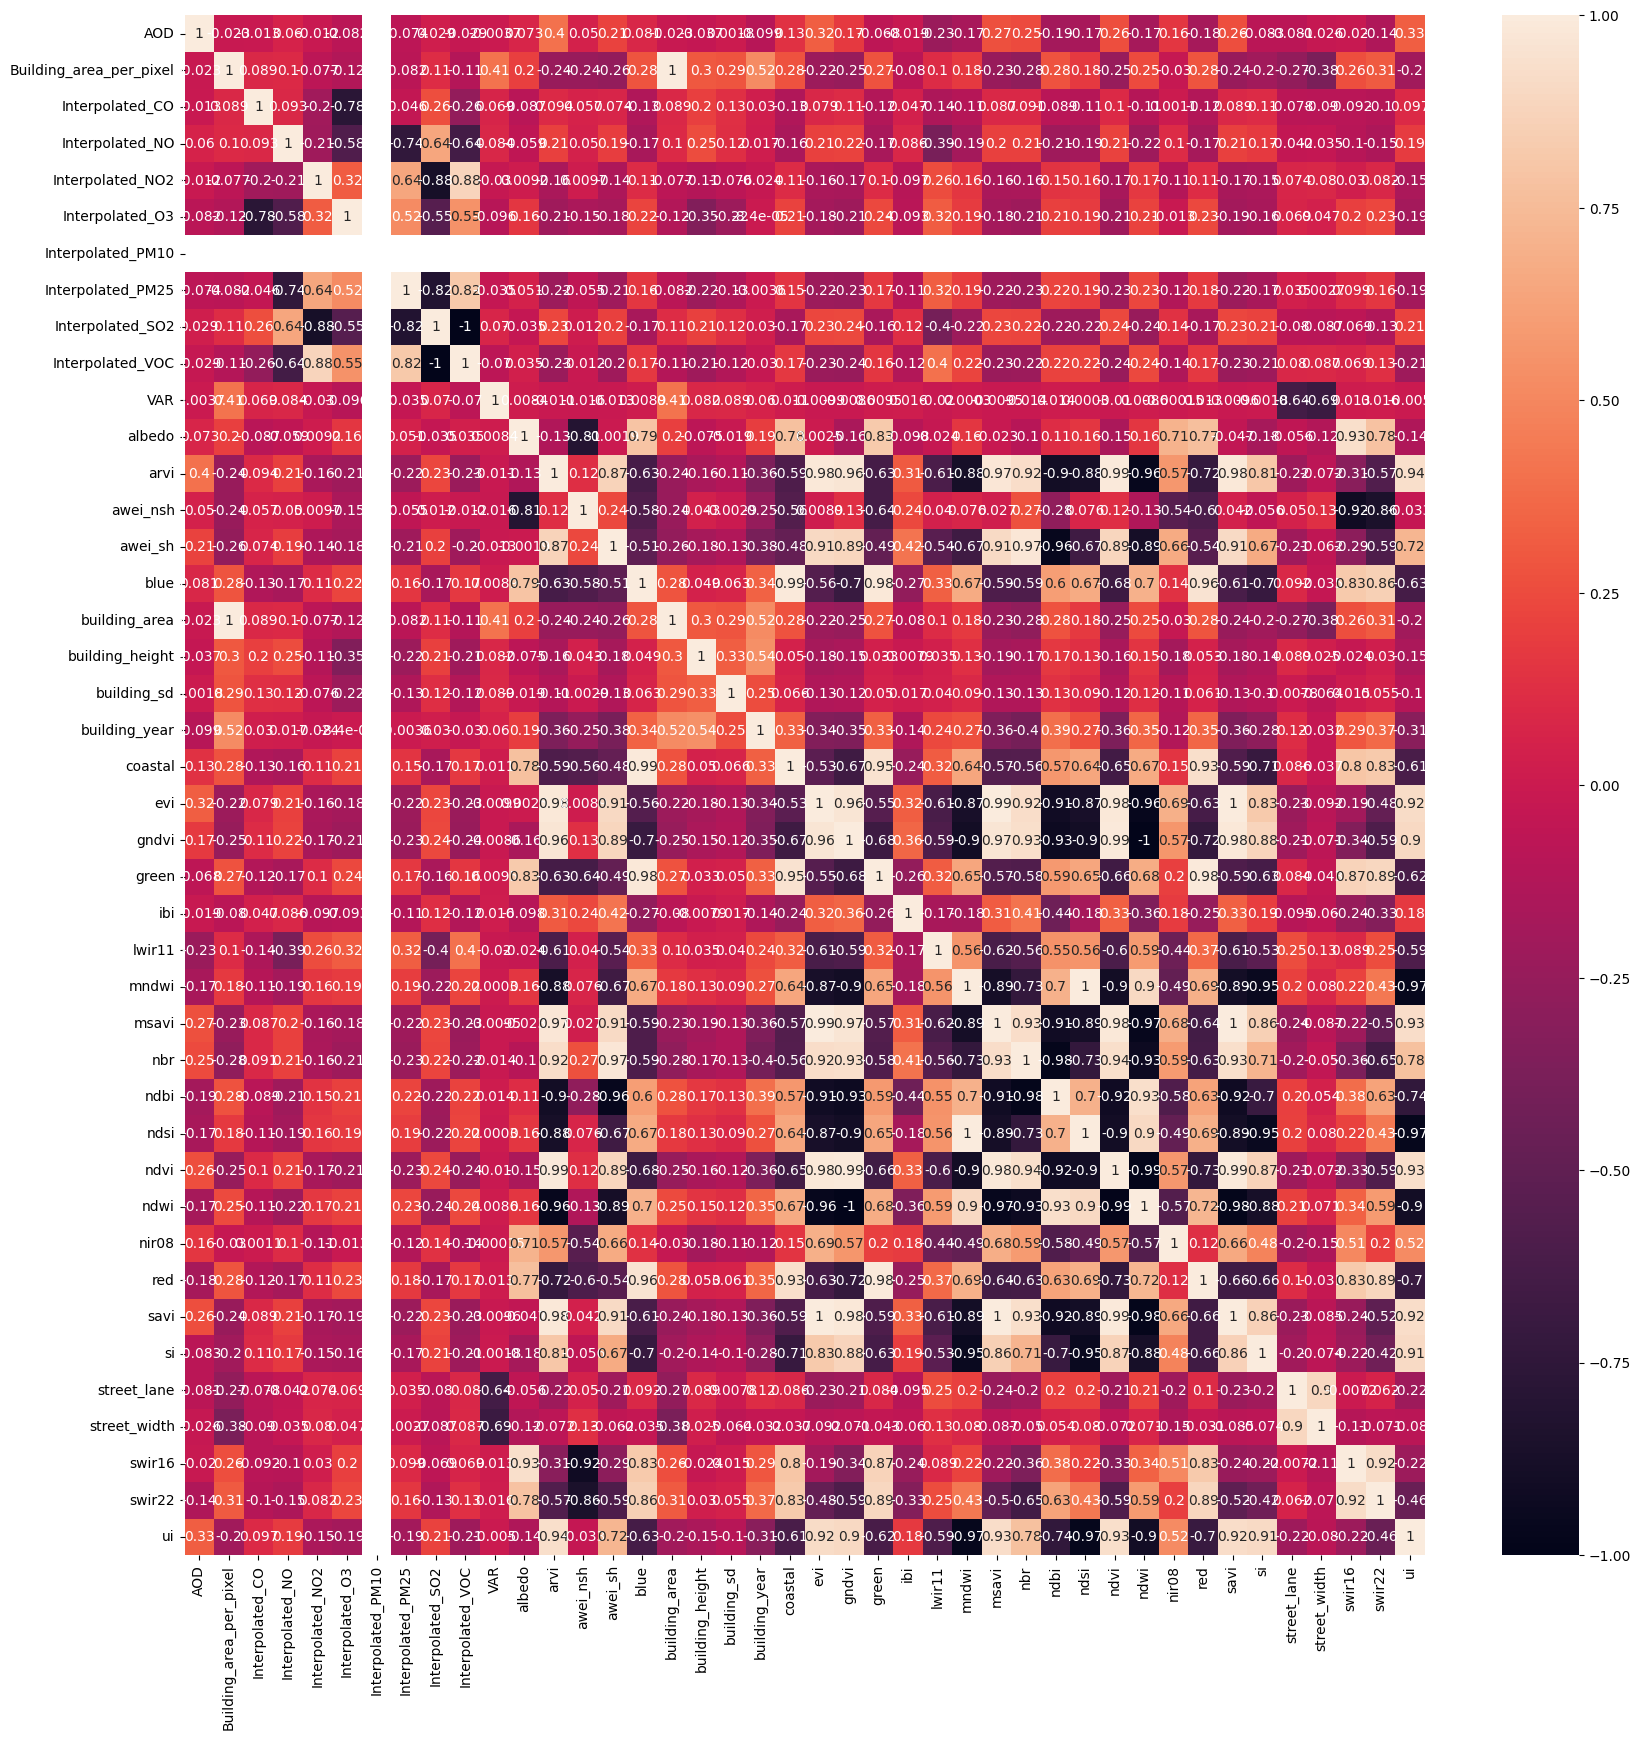

In [204]:
feat_corr = uhi_data[numerical_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(feat_corr, annot=True)

### Model Training

#### Random Forest

In [36]:
# Random Forest 
# rf = RandomForestRegressor(random_state=42)

In [37]:
# rf_param_grid = {
#     "n_estimators":[100, 200, 300],
#     "max_depth": [3, 5, 7, 9],
#     "min_samples_split": [2, 5, 7], 
#     "min_samples_leaf": [1, 2, 4],    
#     "criterion": ['squared_error'],
# }

# rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')
# rf_grid_search.fit(X_train, y_train)

In [38]:
# print("RF Best Parameters:", rf_grid_search.best_params_)
# print("RF Best Score:", rf_grid_search.best_score_)

In [39]:
# rf_best_params = RandomForestRegressor(
#     n_estimators=200,
#     criterion='squared_error',
#     max_depth=10,
#     min_samples_leaf=5,
#     min_samples_split=5,
#     # **rf_grid_search.best_params_,
#     random_state=42
# )
# rf.fit(X_train, y_train)

##### In-Sample Evaluation

In [40]:
# # Perform Cross-validation
# rf_cv_scores = cross_val_score(
#     estimator=rf,
#     X=X_train,
#     y=y_train,
#     cv=KFold(10),
#     scoring='r2'
# )


In [41]:
# print("Cross-validation scores:", rf_cv_scores)
# print("Mean R² score:", np.mean(rf_cv_scores))
# print("Standard Deviation", np.std(rf_cv_scores))

In [42]:
# Make predictions on the training data
# insample_predictions = rf.predict(X_train)

In [43]:
# calculate R-squared score for in-sample predictions
# Y_train = y_train.tolist()
# r2_score(Y_train, insample_predictions)

##### Out-Sample Evaluation

In [44]:
# Make predictions on the test data
# outsample_predictions = rf.predict(X_test)

In [45]:
# calculate R-squared score for out-sample predictions
# Y_test = y_test.tolist()
# r2_score(Y_test, outsample_predictions)

#### XGBoost

In [205]:
# Xtreme Gradient Boosting
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=5,
    colsample_bytree=1,
    subsample=0.8,
    random_state=42
)

In [47]:
# xgb_param_grid = {
#     'n_estimators': [100],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')
# xgb_grid_search.fit(X_train, y_train)

In [48]:
# print("XGB Best Parameters:", xgb_grid_search.best_params_)
# print("XGB Best Score:", xgb_grid_search.best_score_)

In [206]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

##### In-Sample Evaluation

In [169]:
# Perform Cross-Validation 
xgb_cv_scores = cross_val_score(
    estimator=xgb,
    X=X_train,
    y=y_train,
    cv=KFold(10),
    scoring='r2'
)

In [171]:
print("Cross-validation scores:", xgb_cv_scores)
print("Mean R² score:", np.mean(xgb_cv_scores))
print("Standard Deviation", np.std(xgb_cv_scores))

Cross-validation scores: [0.94766114 0.95067488 0.9465219  0.94565834 0.95911491 0.95501802
 0.95289293 0.95047696 0.94121986 0.94729654]
Mean R² score: 0.9496535470733314
Standard Deviation 0.0048675530249717835


In [207]:
# Make predictions on the training data
insample_predictions = xgb.predict(X_train)

In [208]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9948968129553937

##### Out-Sample Evaluation

In [210]:
# Make predictions on the test data
outsample_predictions = xgb.predict(X_test)

In [211]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.9528281660718501

##### Residuals

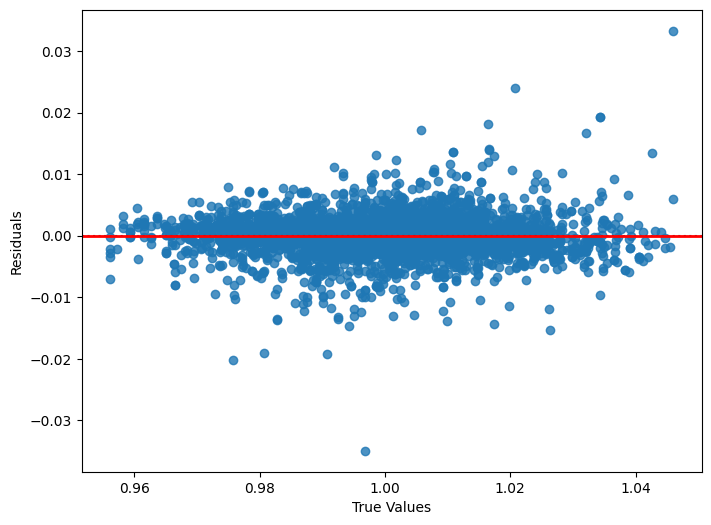

In [212]:
residuals = Y_test - outsample_predictions

plt.figure(figsize=(8, 6))
sns.residplot(x=Y_test, y=residuals, line_kws={"color": "red", "lw": 2})
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

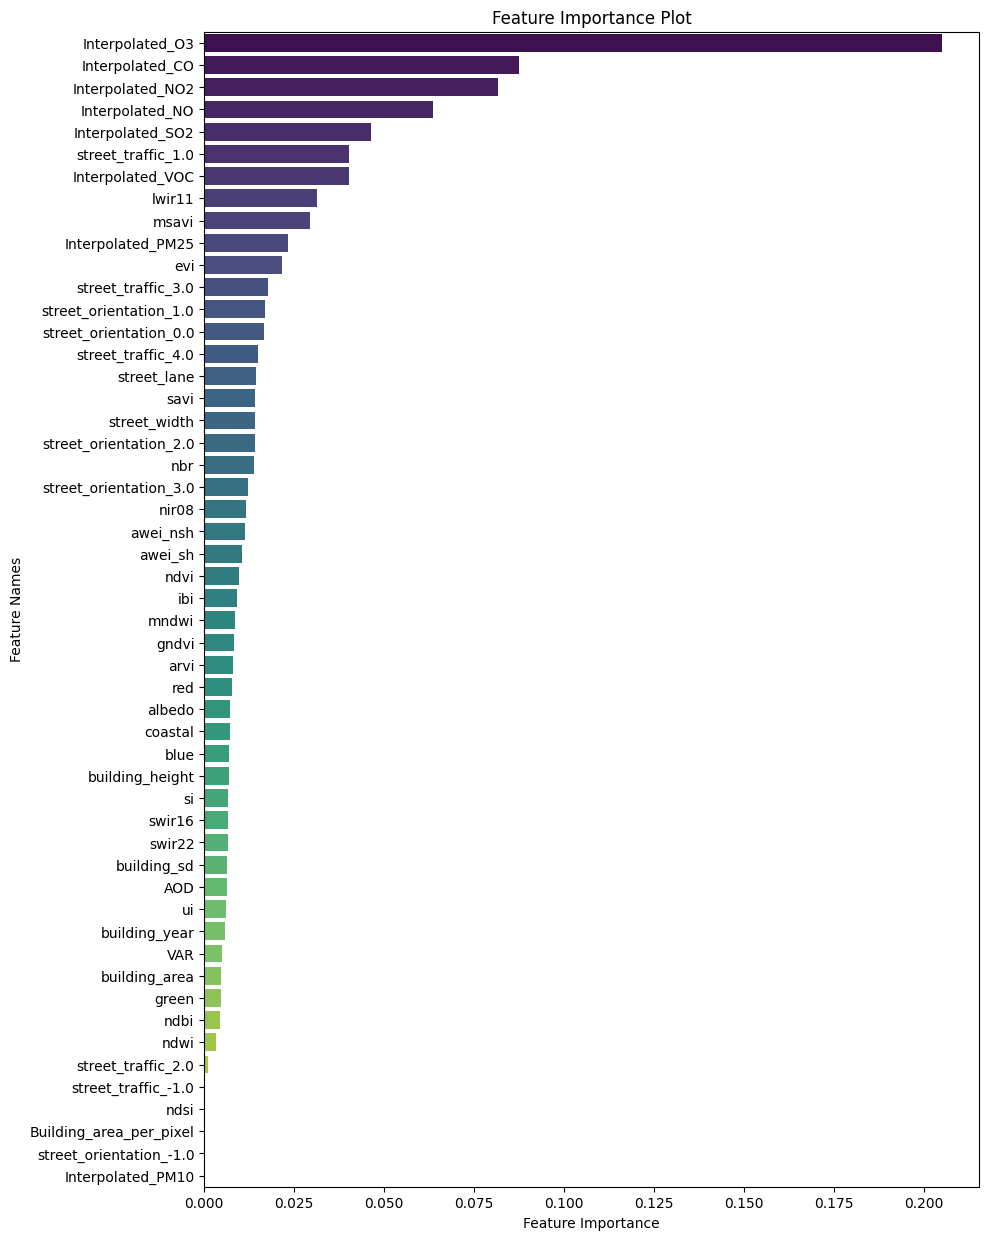

In [213]:
feature_importances = xgb.feature_importances_

feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 15))
sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance Plot")
plt.show()

#### CatBoost


In [58]:
cb = CatBoostRegressor(n_estimators=100, random_state=42)

In [59]:
cb.fit(X_train, y_train)

Learning rate set to 0.368686
0:	learn: 0.0137431	total: 187ms	remaining: 18.5s
1:	learn: 0.0123080	total: 203ms	remaining: 9.97s
2:	learn: 0.0114135	total: 213ms	remaining: 6.9s
3:	learn: 0.0109230	total: 227ms	remaining: 5.44s
4:	learn: 0.0105135	total: 241ms	remaining: 4.58s
5:	learn: 0.0101769	total: 254ms	remaining: 3.98s
6:	learn: 0.0100373	total: 277ms	remaining: 3.68s
7:	learn: 0.0098455	total: 298ms	remaining: 3.43s
8:	learn: 0.0095740	total: 318ms	remaining: 3.21s
9:	learn: 0.0094187	total: 335ms	remaining: 3.02s
10:	learn: 0.0093100	total: 358ms	remaining: 2.89s
11:	learn: 0.0092246	total: 392ms	remaining: 2.88s
12:	learn: 0.0091357	total: 408ms	remaining: 2.73s
13:	learn: 0.0089420	total: 429ms	remaining: 2.63s
14:	learn: 0.0088256	total: 455ms	remaining: 2.58s
15:	learn: 0.0087132	total: 472ms	remaining: 2.48s
16:	learn: 0.0085764	total: 485ms	remaining: 2.37s
17:	learn: 0.0085428	total: 512ms	remaining: 2.33s
18:	learn: 0.0083998	total: 531ms	remaining: 2.26s
19:	learn: 0

##### In-Sample Evaluation

In [151]:
# Perform Cross-Validation 
cb_cv_scores = cross_val_score(
    estimator=cb,
    X=X_train,
    y=y_train,
    cv=KFold(10),
    scoring='r2'
)

Learning rate set to 0.362599
0:	learn: 0.0137817	total: 24.9ms	remaining: 2.46s
1:	learn: 0.0127010	total: 44.8ms	remaining: 2.2s
2:	learn: 0.0115911	total: 62.8ms	remaining: 2.03s
3:	learn: 0.0109329	total: 80.8ms	remaining: 1.94s
4:	learn: 0.0105144	total: 99.4ms	remaining: 1.89s
5:	learn: 0.0101707	total: 121ms	remaining: 1.9s
6:	learn: 0.0099395	total: 144ms	remaining: 1.91s
7:	learn: 0.0098464	total: 159ms	remaining: 1.83s
8:	learn: 0.0097194	total: 176ms	remaining: 1.78s
9:	learn: 0.0094569	total: 194ms	remaining: 1.75s
10:	learn: 0.0092786	total: 227ms	remaining: 1.84s
11:	learn: 0.0091791	total: 246ms	remaining: 1.8s
12:	learn: 0.0090211	total: 270ms	remaining: 1.81s
13:	learn: 0.0089278	total: 287ms	remaining: 1.76s
14:	learn: 0.0087517	total: 304ms	remaining: 1.72s
15:	learn: 0.0086445	total: 318ms	remaining: 1.67s
16:	learn: 0.0084876	total: 339ms	remaining: 1.65s
17:	learn: 0.0083429	total: 359ms	remaining: 1.63s
18:	learn: 0.0082572	total: 379ms	remaining: 1.62s
19:	learn

In [61]:
print("Cross-validation scores:", cb_cv_scores)
print("Mean R² score:", np.mean(cb_cv_scores))
print("Standard Deviation", np.std(cb_cv_scores))

Cross-validation scores: [0.87242123 0.87125329 0.87310724 0.87464561 0.88606961 0.87546865
 0.88409095 0.87296341 0.85792032 0.88194994]
Mean R² score: 0.8749890246577857
Standard Deviation 0.007576021686437456


In [62]:
# Make predictions on the training data
insample_predictions = cb.predict(X_train)

In [63]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9210370943775805

##### Out-Sample Evaluation

In [64]:
# Make predictions on the test data
outsample_predictions = cb.predict(X_test)

In [65]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8807676117986696

#### Save Model

In [66]:
# import joblib

# RF_SAVE_DIR = 'models/RandomForest/'
# XGB_SAVE_DIR = 'models/XGB/'
# CB_SAVE_DIR = 'models/CatBoost'


# joblib.dump(rf, RF_SAVE_DIR + 'random_forest(default_params_and_all_features).pkl')

# joblib.dump(xgb, XGB_SAVE_DIR + 'xgb(default_params_and_all_features).pkl')

# joblib.dump()

# print("Model saved successfully!")

## Model Evaluation

In [67]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(model, X_test, Y_test, n_repeats=10, random_state=42)
# print(result.importances_mean)

In [68]:
# features = uhi_data.drop(columns=['UHI Index']).columns
# importance_mean = result.importances_mean

In [69]:
# plt.barh(features, importance_mean, color='skyblue')
# plt.xlabel("Mean Permutation Importance")
# plt.ylabel("Feature")
# plt.title("Permutation Feature Importance")
# plt.show()

## Submission

In [152]:
#Reading the coordinates for the submission
test_file = pd.read_csv('data/Submission_template_UHI2025-v2.csv')
test_file

Longitude   Latitude  UHI Index
0    -73.971665  40.788763        NaN
1    -73.971928  40.788875        NaN
2    -73.967080  40.789080        NaN
3    -73.972550  40.789082        NaN
4    -73.969697  40.787953        NaN
...         ...        ...        ...
1035 -73.919388  40.813803        NaN
1036 -73.931033  40.833178        NaN
1037 -73.934647  40.854542        NaN
1038 -73.917223  40.815413        NaN
1039 -73.911645  40.804402        NaN

[1040 rows x 3 columns]

In [153]:
# Mapping satellite data for submission.
val_data1 = map_satellite_data(data_dir + 'landsat_8.tiff', 'data/Submission_template_UHI2025-v2.csv', landsat_bands)
val_data2 = map_satellite_data(data_dir + 'building_res30.tiff', 'data/Submission_template_UHI2025-v2.csv', building_bands)
val_data3 = map_satellite_data(data_dir + 'street_res30.tiff', 'data/Submission_template_UHI2025-v2.csv', street_bands)
val_data = pd.concat([val_data1, val_data2, val_data3], axis=1)

Go through layer:   0%|          | 0/8 [00:00<?, ?it/s]

Go through layer: 100%|██████████| 4/4 [00:18<00:00,  4.63s/it]


In [154]:
# val_data['ndvi'] = (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + val_data['red'])
# val_data['ndvi'] = val_data['ndvi'].replace([np.inf, -np.inf], np.nan)

# val_data['ndbi'] = (val_data['swir16'] - val_data['nir08']) / (val_data['swir16'] + val_data['nir08'])
# val_data['ndbi'] = val_data['ndbi'].replace([np.inf, -np.inf], np.nan)

# val_data['ndwi'] = (val_data['green'] - val_data['nir08']) / (val_data['green'] + val_data['nir08'])
# val_data['ndwi'] = val_data['ndwi'].replace([np.inf, -np.inf], np.nan)

# val_data['VAR'] = val_data['building_height'] / val_data['street_width']
# val_data['VAR'] = val_data['VAR'].replace([np.inf, -np.inf], np.nan)

# val_data['Building_area_per_pixel'] = val_data['building_area'] / (900 * 10.764)
# val_data['Building_area_per_pixel'] = val_data['Building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

# val_data['albedo'] = 0.356 * val_data['blue'] + 0.130 * val_data['red'] + 0.373 * val_data['nir08'] + 0.085 * val_data['swir16'] + 0.072 * val_data['swir22'] - 0.018

# NDVI (Normalized Difference Vegetation Index) 
val_data['ndvi'] = (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + val_data['red'])

# EVI (Enhanced Vegetation Index)
val_data["evi"] = 2.5 * (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + 6 * val_data['red'] - 7.5 * val_data['blue'] + 1 + 1e-10)

# SAVI (Soil Adjusted Vegetation Index)
val_data["savi"] = (val_data['nir08'] - val_data['red']) * 1.5 / (val_data['nir08'] + val_data['red'] + 0.5 + 1e-10)

# GNDVI (Green Normalized Difference Vegetation Index)
val_data["gndvi"] = (val_data['nir08'] - val_data['green']) / (val_data['nir08'] + val_data['green'] + 1e-10)

# ARVI (Atmospherically Resistant Vegetation Index)
val_data["arvi"] = (val_data['nir08'] - (val_data['red'] - (val_data['blue'] - val_data['red']))) / (val_data['nir08'] + (val_data['red'] - (val_data['blue'] - val_data['red'])) + 1e-10)

# MSAVI (Modified Soil-Adjusted Vegetation Index)
val_data["msavi"] = (2 * val_data['nir08'] + 1 - ((2 * val_data['nir08'] + 1) ** 2 - 8 * (val_data['nir08'] - val_data['red'])) ** 0.5) / 2

# NDWI (Normalized Difference Water Index)
val_data['ndwi'] = (val_data['green'] - val_data['nir08']) / (val_data['green'] + val_data['nir08'])

# MNDWI (Modified Normalized Difference Water Index)
val_data["mndwi"] = (val_data['green'] - val_data['swir16']) / (val_data['green'] + val_data['swir16'] + 1e-10)

# AWEI_NSH (Automated Water Extraction Index - No Shadows)
val_data["awei_nsh"] = 4 * (val_data['green'] - val_data['swir16']) - (0.25 * val_data['nir08'] + 2.75 * val_data['swir22'])

# AWEI_SH (Automated Water Extraction Index - Shadows)
val_data["awei_sh"] = val_data['green'] + 2.5 * val_data['nir08'] - 1.5 * (val_data['swir16'] + val_data['swir22']) - 0.25 * val_data['blue']

# NDSI (Normalized Difference Snow Index)
val_data["ndsi"] = (val_data['green'] - val_data['swir16']) / (val_data['green'] + val_data['swir16'] + 1e-10)

# NBR (Normalized Burn Ratio)
val_data["nbr"] = (val_data['nir08'] - val_data['swir22']) / (val_data['nir08'] + val_data['swir22'] + 1e-10)

# SI (Shadow Index or Soil Index)
val_data["si"] = (val_data['swir16'] - val_data['blue']) / (val_data['swir16'] + val_data['blue'] + 1e-10)

# NDBI (Normalized Difference Building Index)
val_data['ndbi'] = (val_data['swir16'] - val_data['nir08']) / (val_data['swir16'] + val_data['nir08'])

# UI (Urban Index)
val_data["ui"] = (val_data['swir16'] - val_data['red']) / (val_data['swir16'] + val_data['red'] + 1e-10)

# IBI (Index-based Built-up Index)
val_data["ibi"] = (val_data["ndbi"] - (val_data["savi"] + val_data["mndwi"])) / (val_data["ndbi"] + (val_data["savi"] + val_data["mndwi"]) + 1e-10)

# Albedo (Surface Reflectance Index)
val_data['albedo'] = (0.356 * val_data['blue'] + 0.130 * val_data['red'] + 0.373 * val_data['nir08'] + 0.085 * val_data['swir16'] + 0.072 * val_data['swir22'] - 0.018) / 1.016


In [155]:
# Calculate the VAR (Vertical Aspect Ratio)
val_data['VAR'] = val_data['building_height'] / val_data['street_width']
val_data['VAR'] = val_data['VAR'].replace([np.inf, -np.inf], np.nan)

# Calculate the building's area per pixel area (30 x 30 m^2)
val_data['Building_area_per_pixel'] = val_data['building_area'] / (900 * 10.764)
val_data['Building_area_per_pixel'] = val_data['Building_area_per_pixel'].replace([np.inf, -np.inf], np.nan)

In [156]:
# # AOD (Aerosol Optical Depth)
# val_data['AOD'] = val_data['blue'] / val_data['red'] + 1e-10

# # PM2.5
# conversion_factor = 52
# val_data['PM_2.5'] = val_data['AOD'] * conversion_factor + 1e-10

# # NO2
# val_data['NO2'] = val_data['blue'] / val_data['green'] + 1e-10

# # SO2
# val_data['SO2'] = val_data['swir16'] - val_data['swir22'] + 1e-10
val_data

red                 blue                green  \
0     0.061580000000000024  0.05170750000000002  0.07354250000000001   
1     0.061580000000000024  0.05170750000000002  0.07354250000000001   
2                   0.1432  0.11163000000000001            0.1309075   
3                0.1856875  0.13085249999999998  0.17215750000000002   
4      0.12166749999999998  0.12287749999999997  0.12205250000000001   
...                    ...                  ...                  ...   
1035               0.14298  0.10453499999999999  0.12425249999999999   
1036              0.133795  0.11179499999999998            0.1463625   
1037   0.15425499999999998  0.10827500000000001  0.14012000000000002   
1038   0.22058500000000003            0.1849175              0.20293   
1039             0.1437775  0.10761500000000002            0.1311275   

                    nir08               swir16               swir22  \
0               0.2785275  0.15694999999999998  0.09744000000000003   
1               0.2785275  0.15694999999999998  0.09744000000000003   
2               0.1695175  0.17394500000000002  0.16019499999999998   
3     0.22102500000000003              0.23373            0.2094475   
4               0.2677475              0.22218  0.16286250000000002   
...                   ...                  ...                  ...   
1035  0.17653000000000002            0.1961925  0.20735750000000003   
1036            0.3164775  0.23606749999999999             0.158325   
1037  0.24288749999999998              0.21019            0.1721025   
1038            0.2938175            0.3075125            0.2813325   
1039            0.1765025            0.1724325  0.14683000000000002   

                  coastal              lwir11 building_height building_sd  \
0               0.0476375  36.202990279999995            62.0         0.0   
1               0.0476375  36.202990279999995            62.0         0.0   
2     0.09994249999999999  36.069687499999986       235.43724         0.0   
3     0.11088750000000003  36.886594280000054           70.91    12.13869   
4     0.12026500000000001   34.50081632000001       52.617714   7.3591685   
...                   ...                 ...             ...         ...   
1035             0.097495  39.754313060000015            33.5         2.5   
1036            0.0987325   34.92806882000002       13.105746         0.0   
1037            0.0924625   38.85537380000005           70.65         0.0   
1038  0.17114000000000001  39.200593819999995          22.355       2.785   
1039  0.09562500000000002  39.409093040000016             0.0        -1.0   

     building_year building_area street_width street_traffic street_lane  \
0           1989.0     2369.9119         30.0            4.0         3.0   
1           1989.0     63.584137         30.0            4.0         3.0   
2           1931.0      4479.868          0.0           -1.0         0.0   
3           1905.8     1932.5002         30.0            4.0         3.0   
4        1893.1428     2381.5554         32.0            4.0         3.0   
...            ...           ...          ...            ...         ...   
1035        2004.0     962.42755         60.0            3.0         6.0   
1036        1929.0     128.28859         26.0            2.0         2.5   
1037        1941.0     5.2778025         32.0            1.0         3.5   
1038        1960.5     2737.7239         23.0            4.0         2.0   
1039           0.0           0.0    34.555557            4.0   2.5555556   

     street_orientation      ndvi       evi      savi     gndvi      arvi  \
0                   3.0  0.637879  0.430383  0.387357  0.582228  0.591677   
1                   3.0  0.637879  0.430383  0.387357  0.582228  0.591677   
2                  -1.0  0.084157   0.05522  0.048573  0.128518 -0.015256   
3                   3.0  0.086886  0.065258   0.05846  0.124287 -0.042244   
4                   3.0  0.375127  0.339351  0.246364  0.373769  0.379413   
...  

In [ ]:
air_quality_files = {
    "CO": "data_pipeline\\data\\air_quality\\co_data_mean_and_std.csv",
    "SO2": "data_pipeline\\data\\air_quality\\so2_data_mean_and_std.csv",
    "NO2": "data_pipeline\\data\\air_quality\\no2_data_mean_and_std.csv",
    "O3": "data_pipeline\\data\\air_quality\\o3_data_mean_and_std.csv",
    "PM10": "data_pipeline\\data\\air_quality\\pm10_data_mean_and_std.csv",
    "PM25": "data_pipeline\\data\\air_quality\\pm2.5_data_mean_and_std.csv",
    "VOC": "data_pipeline\\data\\air_quality\\voc_data_mean_and_std.csv",
    "NO": "data_pipeline\\data\\air_quality\\no_data_mean_and_std.csv",
}

# # Iterate over each air quality dataset and map values using KNN
# for key, file_path in air_quality_files.items():
#     # Load the air quality dataset
#     air_quality_data = pd.read_csv(file_path)
    
#     # Extract coordinates and values
#     aq_coords = air_quality_data[["longitude", "latitude"]].values
#     avg_values = air_quality_data[f"average_{key}"].values
#     std_values = air_quality_data[f"std_{key}"].values
    
#     # Create KDTree for nearest neighbor search
#     tree = cKDTree(aq_coords)
    
#     # Find the nearest point for each coordinate in the main dataset
#     distances, indices = tree.query(test_file[['Longitude', 'Latitude']], k=1)  # k=1 means nearest neighbor
    
#     # Assign values to the main dataset
#     val_data[f"Mean_nearest_{key}"] = avg_values[indices]
#     val_data[f"Std_{key}"] = std_values[indices]
    
# # AOD (Aerosol Optical Depth)
# val_data['AOD'] = val_data['blue'] / val_data['red'] + 1e-10

def idw_interpolation(air_quality_file, param_name, power=1):
    """ Apply IDW interpolation for a given air quality parameter. """
    
    # Load air quality data
    air_quality_df = pd.read_csv(air_quality_file)
    
    # Extract known data points
    known_lons = air_quality_df["longitude"].values
    known_lats = air_quality_df["latitude"].values
    known_values = air_quality_df["average_" + param_name].values  # Using mean values
    
    # Create KDTree for fast nearest neighbor search
    tree = cKDTree(list(zip(known_lons, known_lats)))

    # Perform interpolation for each point in df
    interpolated_values = []
    for lon, lat in zip(test_file["Longitude"], test_file["Latitude"]):
        distances, indices = tree.query([lon, lat], k=len(known_lons))  # Use all available points

        if len(known_values) < 2:
            interpolated_values.append(np.nan) 
            continue

        weights = 1 / (distances**power + 1e-10)
        interpolated_value = np.sum(weights * known_values[indices]) / np.sum(weights)
        interpolated_values.append(interpolated_value)

    # Add interpolated values to df
    val_data["Interpolated_" + param_name] = interpolated_values

# Apply IDW for each air quality parameter
for param, file_path in air_quality_files.items():
    idw_interpolation(file_path, param)

# AOD (Aerosol Optical Depth)
val_data['AOD'] = val_data['blue'] / val_data['red'] + 1e-10

In [158]:
val_data[numerical_cols] = val_data[numerical_cols].astype('float')

val_data[categorical_cols] = val_data[categorical_cols].astype('float')
val_data[categorical_cols] = val_data[categorical_cols].astype('category')

In [159]:
val_data['VAR'].fillna(1000, inplace=True)
val_data.drop(columns=['Interpolated_PM10'], inplace=True)

In [160]:
val_data = pd.get_dummies(data=val_data, columns=categorical_cols)

In [79]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   red                      1040 non-null   float64
 1   blue                     1040 non-null   float64
 2   green                    1040 non-null   float64
 3   nir08                    1040 non-null   float64
 4   swir16                   1040 non-null   float64
 5   swir22                   1040 non-null   float64
 6   coastal                  1040 non-null   float64
 7   lwir11                   1040 non-null   float64
 8   building_height          1040 non-null   float64
 9   building_sd              1040 non-null   float64
 10  building_year            1040 non-null   float64
 11  building_area            1040 non-null   float64
 12  street_width             1040 non-null   float64
 13  street_lane              1040 non-null   float64
 14  ndvi                    

In [161]:
val_data

red      blue     green     nir08    swir16    swir22   coastal  \
0     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
1     0.061580  0.051708  0.073543  0.278527  0.156950  0.097440  0.047637   
2     0.143200  0.111630  0.130908  0.169517  0.173945  0.160195  0.099942   
3     0.185688  0.130852  0.172158  0.221025  0.233730  0.209448  0.110888   
4     0.121667  0.122877  0.122053  0.267748  0.222180  0.162863  0.120265   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.142980  0.104535  0.124252  0.176530  0.196192  0.207358  0.097495   
1036  0.133795  0.111795  0.146363  0.316478  0.236067  0.158325  0.098733   
1037  0.154255  0.108275  0.140120  0.242887  0.210190  0.172102  0.092463   
1038  0.220585  0.184918  0.202930  0.293818  0.307513  0.281332  0.171140   
1039  0.143778  0.107615  0.131128  0.176503  0.172432  0.146830  0.095625   

         lwir11  building_height  building_sd  building_year  building_area  \
0     36.202990        62.000000     0.000000    1989.000000    2369.911865   
1     36.202990        62.000000     0.000000    1989.000000      63.584137   
2     36.069687       235.437241     0.000000    1931.000000    4479.868164   
3     36.886594        70.910004    12.138690    1905.800049    1932.500244   
4     34.500816        52.617714     7.359169    1893.142822    2381.555420   
...         ...              ...          ...            ...            ...   
1035  39.754313        33.500000     2.500000    2004.000000     962.427551   
1036  34.928069        13.105746     0.000000    1929.000000     128.288589   
1037  38.855374        70.650002     0.000000    1941.000000       5.277802   
1038  39.200594        22.355000     2.785000    1960.500000    2737.723877   
1039  39.409093         0.000000    -1.000000       0.000000       0.000000   

      street_width  street_lane      ndvi       evi      savi     gndvi  \
0        30.000000     3.000000  0.637879  0.430383  0.387357  0.582228   
1        30.000000     3.000000  0.637879  0.430383  0.387357  0.582228   
2         0.000000     0.000000  0.084157  0.055220  0.048573  0.128518   
3        30.000000     3.000000  0.086886  0.065258  0.058460  0.124287   
4        32.000000     3.000000  0.375127  0.339351  0.246364  0.373769   
...            ...          ...       ...       ...       ...       ...   
1035     60.000000     6.000000  0.105005  0.067079  0.061409  0.173805   
1036     26.000000     2.500000  0.405715  0.356583  0.288363  0.367546   
1037     32.000000     3.500000  0.223176  0.163365  0.148191  0.268317   
1038     23.000000     2.000000  0.142364  0.148793  0.108289  0.182965   
1039     34.555557     2.555556  0.102176  0.066403  0.059842  0.147499   

          arvi     msavi      ndwi     mndwi  awei_nsh   awei_sh      ndsi  \
0     0.591677  0.363545 -0.582228 -0.361866 -0.671222  0.375349 -0.361866   
1     0.591677  0.363545 -0.582228 -0.361866 -0.671222  0.375349 -0.361866   
2    -0.015256  0.040535 -0.128518 -0.141175 -0.655066  0.025584 -0.141175   
3    -0.042244  0.050800 -0.124287 -0.151698 -0.877527  0.027241 -0.151698   
4     0.379413  0.222517 -0.373769 -0.290872 -0.915319  0.183138 -0.290872   
...        ...       ...       ...       ...       ...       ...       ...   
1035 -0.013675  0.051556 -0.173805 -0.224500 -0.902126 -0.065881 -0.224500   
1036  0.340233  0.267596 -0.367546 -0.234566 -0.873333  0.318019 -0.234566   
1037  0.096254  0.130828 -0.268317 -0.200023 -0.814284  0.146831 -0.200023   
1038  0.068291  0.098346 -0.182965 -0.204886 -1.265449  0.007977 -0.204886   
1039 -0.009644  0.050239 -0.147499 -0.136069 -0.613128  0.066586 -0.136069   

           nbr        si      ndbi        ui       ibi    albedo          VAR  \
0     0.481657  0.504379 -0.279182  0.436416  1.200954  0.130571     2.066667   
1     0.481657  0.504379 -0.279182  0.436416  1.200954  0.130571     2.066667   
2     0.028275  0.218209  0.012891  0.096943

In [162]:
# Feature Scaling 
submission_val_data = val_data[numerical_cols]
transformed_submission_data = sc.transform(submission_val_data)
val_data[numerical_cols] = sc.transform(val_data[numerical_cols])

In [163]:
transformed_submission_data = val_data.copy()
transformed_submission_data = transformed_submission_data[X_train.columns]
transformed_submission_data

red      blue     green     nir08    swir16    swir22   coastal  \
0    -1.472449 -1.336227 -1.253464  0.914234 -0.868294 -1.303691 -1.281882   
1    -1.472449 -1.336227 -1.253464  0.914234 -0.868294 -1.303691 -1.281882   
2     0.089339  0.094133  0.013677 -0.916517 -0.531995 -0.142380  0.108736   
3     0.902331  0.552977  0.924852 -0.051482  0.651039  0.769060  0.399728   
4    -0.322683  0.362613 -0.181922  0.733191  0.422486 -0.093017  0.649044   
...        ...       ...       ...       ...       ...       ...       ...   
1035  0.085129 -0.075226 -0.133326 -0.798746 -0.091759  0.730384  0.043665   
1036 -0.090625  0.098072  0.355064  1.551579  0.697293 -0.176985  0.076566   
1037  0.300875  0.014049  0.217173  0.315684  0.185226  0.077974 -0.090133   
1038  1.570090  1.843518  1.604589  1.171019  2.111057  2.099326  2.001643   
1039  0.100389 -0.001706  0.018537 -0.799208 -0.561925 -0.389706 -0.006052   

        lwir11  building_height  building_sd  building_year  building_area  \
0    -0.283055         0.108603    -0.322351       0.728095       0.857263   
1    -0.283055         0.108603    -0.322351       0.728095      -0.725704   
2    -0.337101         2.630876    -0.322351       0.663523       2.305450   
3    -0.005895         0.238180     0.333492       0.635467       0.557042   
4    -0.973184        -0.027843     0.075259       0.621376       0.865255   
...        ...              ...          ...            ...            ...   
1035  1.156793        -0.305869    -0.187278       0.744794      -0.108775   
1036 -0.799959        -0.602460    -0.322351       0.661296      -0.681293   
1037  0.792327         0.234398    -0.322351       0.674656      -0.765723   
1038  0.932293        -0.467949    -0.171880       0.696365       1.109714   
1039  1.016827        -0.793055    -0.376380      -1.486275      -0.769345   

      street_width  street_lane      ndvi       evi      savi     gndvi  \
0        -0.559231    -0.301622  2.080211  1.877130  1.932577  1.923191   
1        -0.559231    -0.301622  2.080211  1.877130  1.932577  1.923191   
2        -2.395997    -2.227289 -0.801252 -0.818960 -0.803452 -0.813039   
3        -0.559231    -0.301622 -0.787055 -0.746818 -0.723607 -0.838554   
4        -0.436780    -0.301622  0.712897  1.222937  0.793916  0.666017   
...            ...          ...       ...       ...       ...       ...   
1035      1.277535     1.624045 -0.692768 -0.733735 -0.699792 -0.539922   
1036     -0.804133    -0.622566  0.872075  1.346774  1.133103  0.628490   
1037     -0.436780     0.019323 -0.077828 -0.041777  0.001068  0.030061   
1038     -0.987810    -0.943511 -0.498355 -0.146503 -0.321184 -0.484679   
1039     -0.280315    -0.586906 -0.707486 -0.738589 -0.712442 -0.698570   

          arvi     msavi      ndwi     mndwi  awei_nsh   awei_sh      ndsi  \
0     2.088151  1.860839 -1.923191 -1.447074  0.624434  1.748762 -1.447074   
1     2.088151  1.860839 -1.923191 -1.447074  0.624434  1.748762 -1.447074   
2    -0.762473 -0.760485  0.813039  0.878427  0.702846 -0.560822  0.878427   
3    -0.889228 -0.677187  0.838554  0.767536 -0.376838 -0.549881  0.767536   
4     1.091197  0.716351 -0.666017 -0.698979 -0.560255  0.479547 -0.698979   
...        ...       ...       ...       ...       ...       ...       ...   
1035 -0.755047 -0.671051  0.539922  0.000399 -0.496224 -1.164786  0.000399   
1036  0.907176  1.082183 -0.628490 -0.105665 -0.356484  1.370195 -0.105665   
1037 -0.238734 -0.027733 -0.030061  0.258326 -0.069896  0.239804  0.258326   
1038 -0.370070 -0.291338  0.484679  0.207082 -2.259562 -0.677084  0.207082   
1039 -0.736114 -0.681734  0.698570  0.932233  0.906384 -0.290073  0.932233   

           nbr        si      ndbi        ui       ibi    albedo       VAR  \
0     2.013250  1.593783 -2.002758  1.818655  0.583196 -0.460414 -0.285900   
1     2.013250  1.593783 -2.002758  1.818655  0.583196 -0.460414 -0.285900   
2    -0.684603 -0.845057  0.557481 -0.811417 -0.109840 -0.529236 

In [164]:
#Making predictions
final_predictions = xgb.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [165]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df

Longitude     Latitude    UHI Index
count  1040.000000  1040.000000  1040.000000
mean    -73.934816    40.807991     0.999866
std       0.028661     0.023200     0.015875
min     -73.993163    40.758877     0.957268
25%     -73.957030    40.790802     0.988807
50%     -73.934618    40.809553     0.999695
75%     -73.910655    40.823054     1.011094
max     -73.879537    40.859243     1.043009

In [168]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submissions/landsat_all_feature_(new_env_and_air_features_aqs(interpolated_values))_xgb_(custom_hyperparams_2).csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>